<a href="https://colab.research.google.com/github/TMhdSofyan/Prediction-Flow-Zone-Indicator-/blob/main/01_Final_SupervisedML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install jcopml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:00
  Created wheel for jcopml: filename=jcopml-1.2.2-py2.py3-none-any.whl size=32178 sha256=bcc34ca81048fe78725b218a36f9b7ab0b71c5677facc114142d883594587185
  Stored in directory: /root/.cache/pip/wheels/5e/06/58/749e5f1baf2932285758798a92793d4347888826160b025808
Successfully built jcopml


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [12]:
df = pd.read_csv('/content/drive/MyDrive/01_Project_Reservoir_Description/Data/gamma_interp.csv')
df.head()

,LOGFZI,FZI,CGR,DRHO,DT5,GR,HNPO,LLD,LLHR,LLS,MRES,MSFC,NPHI,NPOR,POTA,RHOB,SP,THOR,URAN
0,2.324533,211.121914,31.992576,0.034071,86.073454,47.128474,0.184824,1.484896,1.989065,1.370871,0.067983,1.299775,0.179966,0.179166,1.292815,2.376139,4.092643,2.646898,2.012321
1,2.460043,288.431455,31.976041,0.025724,86.340619,48.285009,0.183564,1.479856,1.984340,1.344729,0.067904,1.278673,0.184376,0.181292,1.281476,2.365824,3.945005,2.688867,1.995077
2,2.438689,274.592462,36.236242,0.009850,87.020905,50.670716,0.181900,1.491390,1.827785,1.336755,0.067821,1.246173,0.187421,0.179666,1.476265,2.335299,4.080146,2.949177,1.992421
3,2.697101,497.852972,42.122592,0.003631,87.951610,53.894521,0.173462,1.559632,1.893686,1.371531,0.067900,1.095846,0.185625,0.182018,1.743465,2.322451,4.771490,3.316663,1.904021
4,2.265888,184.453837,42.361279,0.014313,88.442537,54.477657,0.188333,1.590263,2.136641,1.372559,0.067900,1.328147,0.184468,0.185889,1.781504,2.329119,4.248235,3.220796,1.711496


array([[<Axes: title={'center': 'LOGFZI'}>,
        <Axes: title={'center': 'FZI'}>, <Axes: title={'center': 'CGR'}>,
        <Axes: title={'center': 'DRHO'}>],
       [<Axes: title={'center': 'DT5'}>, <Axes: title={'center': 'GR'}>,
        <Axes: title={'center': 'HNPO'}>,
        <Axes: title={'center': 'LLD'}>],
       [<Axes: title={'center': 'LLHR'}>,
        <Axes: title={'center': 'LLS'}>,
        <Axes: title={'center': 'MRES'}>,
        <Axes: title={'center': 'MSFC'}>],
       [<Axes: title={'center': 'NPHI'}>,
        <Axes: title={'center': 'NPOR'}>,
        <Axes: title={'center': 'POTA'}>,
        <Axes: title={'center': 'RHOB'}>],
       [<Axes: title={'center': 'SP'}>, <Axes: title={'center': 'THOR'}>,
        <Axes: title={'center': 'URAN'}>, <Axes: >]], dtype=object)

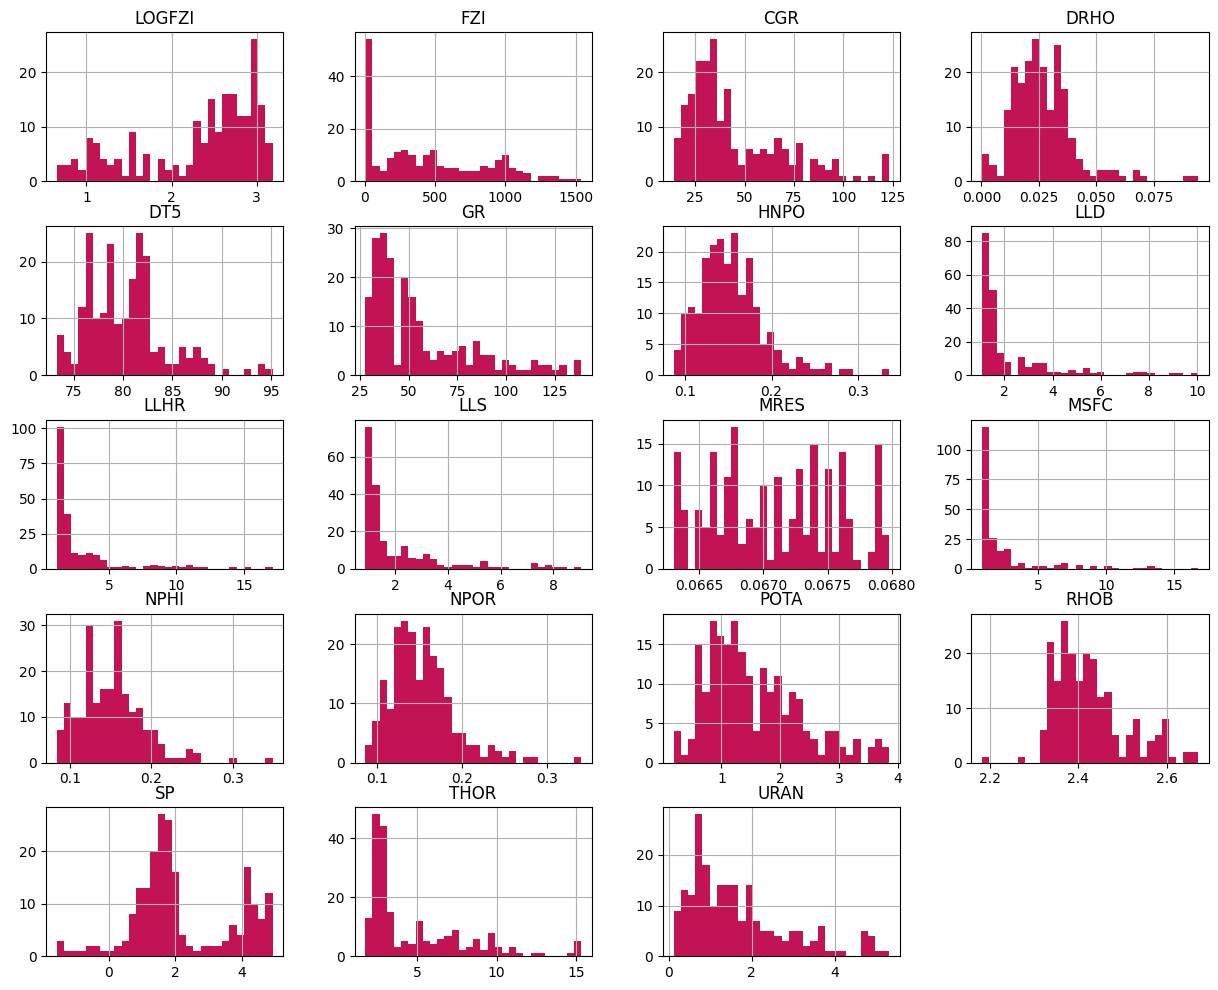

In [8]:
import matplotlib.pyplot as plt

df.hist(bins=30, figsize=(15, 12), color='#c21454')

<Axes: >

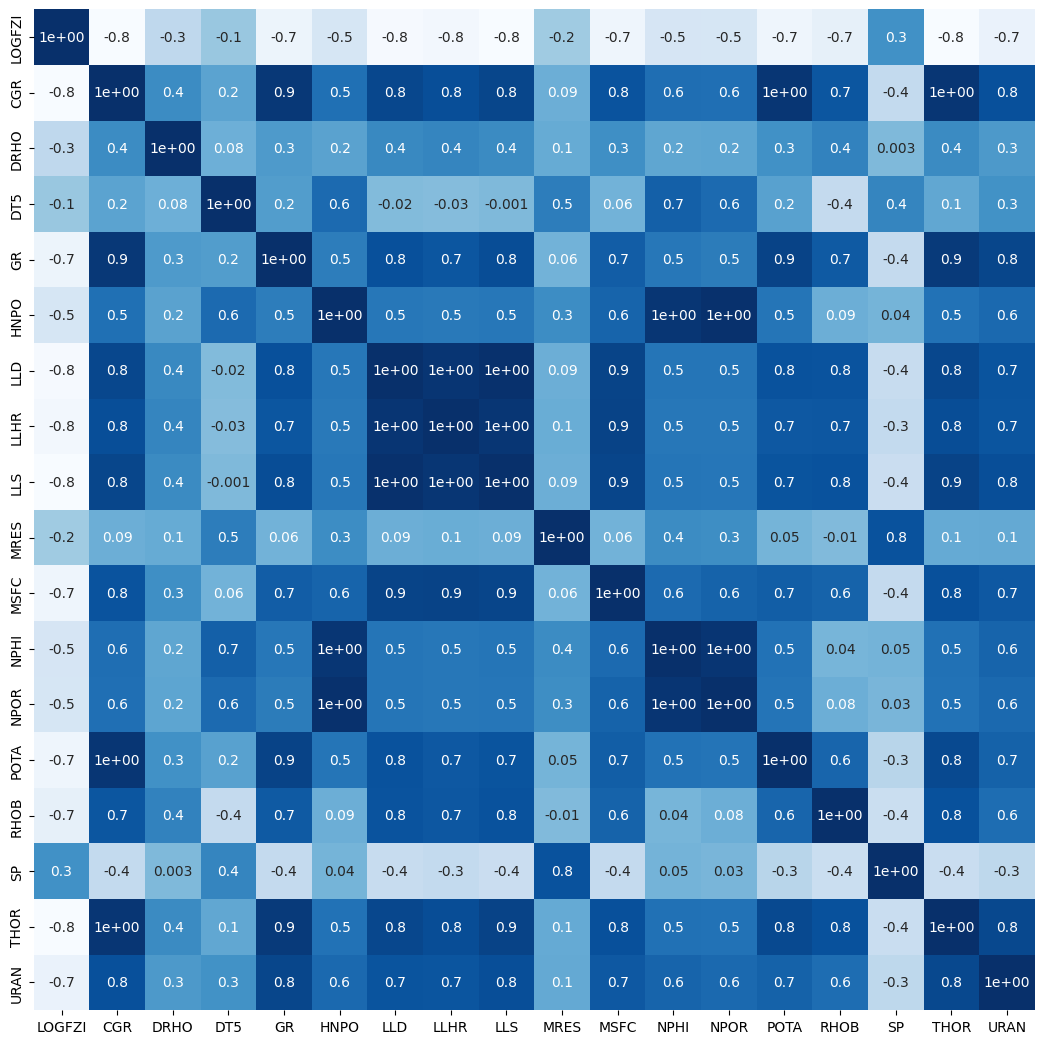

In [13]:
df = df.drop(columns = ['FZI'])
#X = data[['CGR', 'DRHO', 'DT5', 'GR', 'HNPO', 'LLD', 'LLHR', 'LLS', 'MRES', 'MSFC', 'NPHI', 'NPOR', 'RHOB', 'SP', 'THOR', 'URAN', 'POTA']]
#df = df[['LOGFZI', 'CGR', 'GR','LLD', 'LLS','LLHR', 'MRES', 'MSFC', 'NPOR']]

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (13, 13))
sns.heatmap(df.corr(), cmap= "Blues", cbar= False, annot= True, square= True, fmt= '.1')

In [14]:
X = df.drop(columns="LOGFZI")
y = df.LOGFZI

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((159, 17), (53, 17), (159,), (53,))

In [15]:
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gs
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [16]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust', transform='yeo-johnson', poly=2), X.columns)
])

from sklearn.ensemble import RandomForestRegressor
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

model_RF = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_RF.fit(X_train, y_train)

print(model_RF.best_params_)
print(model_RF.score(X_train, y_train), model_RF.best_score_, model_RF.score(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/jcopml/pipeline/_pipeline.py:66: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__max_depth': 70, 'algo__max_features': 0.12828626711806085, 'algo__min_samples_leaf': 7, 'algo__n_estimators': 151}
0.9124889950642902 0.8199064927097616 0.899809313027205


In [21]:
RF_Rank = pd.DataFrame(model_RF.cv_results_).sort_values('rank_test_score', ascending = True)
RF_Rank.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algo__max_depth,param_algo__max_features,param_algo__min_samples_leaf,param_algo__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
33,1.088400,0.020261,0.058571,0.001861,70,0.128286,7,151,"{'algo__max_depth': 70, 'algo__max_features': ...",0.781760,0.812025,0.865934,0.819906,0.034813,1
28,2.206093,0.106022,0.098207,0.020733,52,0.157203,5,198,"{'algo__max_depth': 52, 'algo__max_features': ...",0.778396,0.808089,0.868319,0.818268,0.037410,2
38,1.163020,0.016192,0.051037,0.001095,64,0.36607,6,127,"{'algo__max_depth': 64, 'algo__max_features': ...",0.773923,0.810825,0.863565,0.816104,0.036786,3
3,1.691238,0.456188,0.080832,0.008391,22,0.118526,2,187,"{'algo__max_depth': 22, 'algo__max_features': ...",0.776458,0.819110,0.852708,0.816092,0.031202,4
34,1.620030,0.397344,0.103139,0.026614,80,0.557714,5,122,"{'algo__max_depth': 80, 'algo__max_features': ...",0.776774,0.806874,0.863518,0.815722,0.035962,5


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

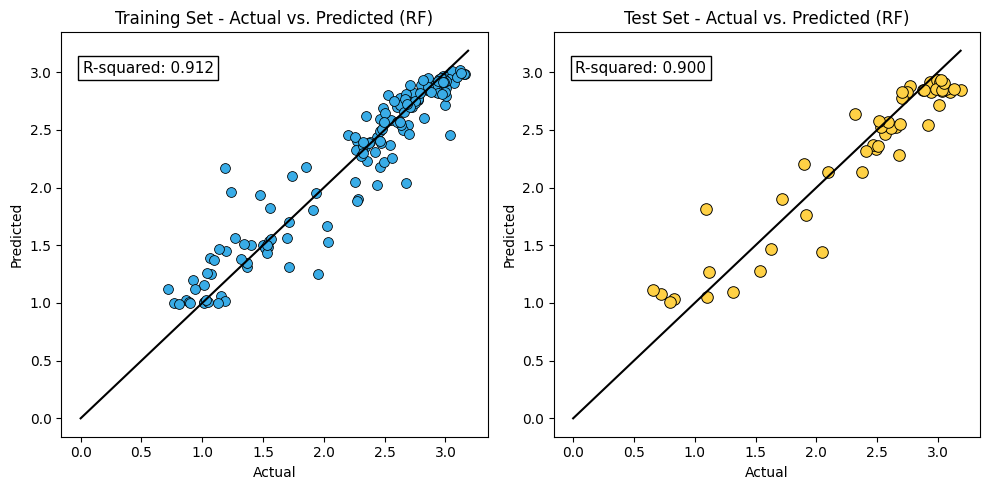

In [24]:
# Predict on training and test sets
y_train_pred = model_RF.predict(X_train)
y_test_pred = model_RF.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].set_title('Training Set - Actual vs. Predicted (RF)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].set_title('Test Set - Actual vs. Predicted (RF)')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

plt.tight_layout()
plt.show()

In [25]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', transform = 'yeo-johnson'), X.columns )])


from xgboost import XGBRegressor
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])


model_XGB = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_XGB.fit(X_train, y_train)

print(model_XGB.best_params_)
print(model_XGB.score(X_train, y_train), model_XGB.best_score_, model_XGB.score(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/jcopml/pipeline/_pipeline.py:66: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.6918516030703091, 'algo__gamma': 1, 'algo__learning_rate': 0.1216411342539395, 'algo__max_depth': 3, 'algo__n_estimators': 185, 'algo__reg_alpha': 0.011502956321912733, 'algo__reg_lambda': 0.009461469059966103, 'algo__subsample': 0.7865052773762229}
0.8910685213579247 0.7981707813035857 0.844082085282035


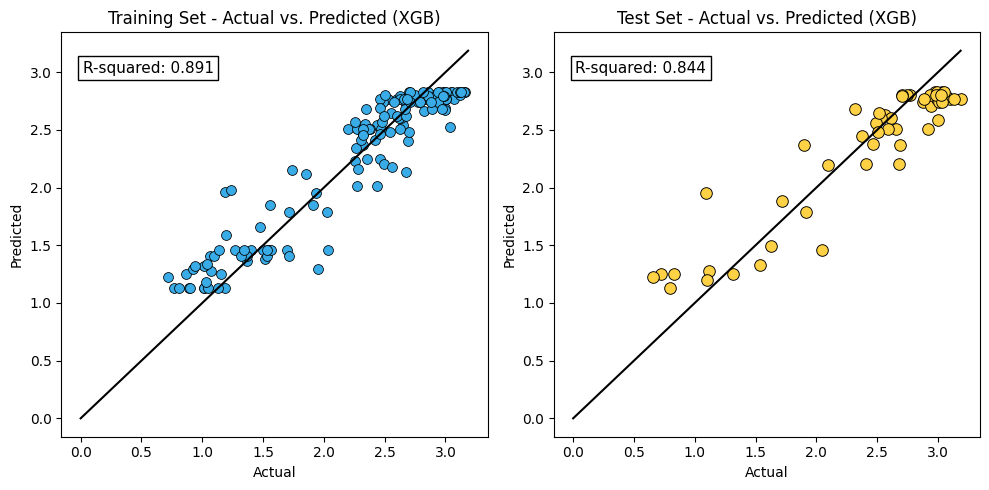

In [26]:
# Predict on training and test sets
y_train_pred = model_XGB.predict(X_train)
y_test_pred = model_XGB.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].set_title('Training Set - Actual vs. Predicted (XGB)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].set_title('Test Set - Actual vs. Predicted (XGB)')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

plt.tight_layout()
plt.show()

In [27]:
from sklearn.svm import SVR
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='minmax'), X.columns )])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])

model_SVM = RandomizedSearchCV(pipeline, rsp.svm_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_SVM.fit(X_train, y_train)

print(model_SVM.best_params_)
print(model_SVM.score(X_train, y_train), model_SVM.best_score_, model_SVM.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__C': 12.746711578215054, 'algo__gamma': 0.4374364439939081}
0.9239807233793689 0.8441520720665184 0.8824080735157898


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


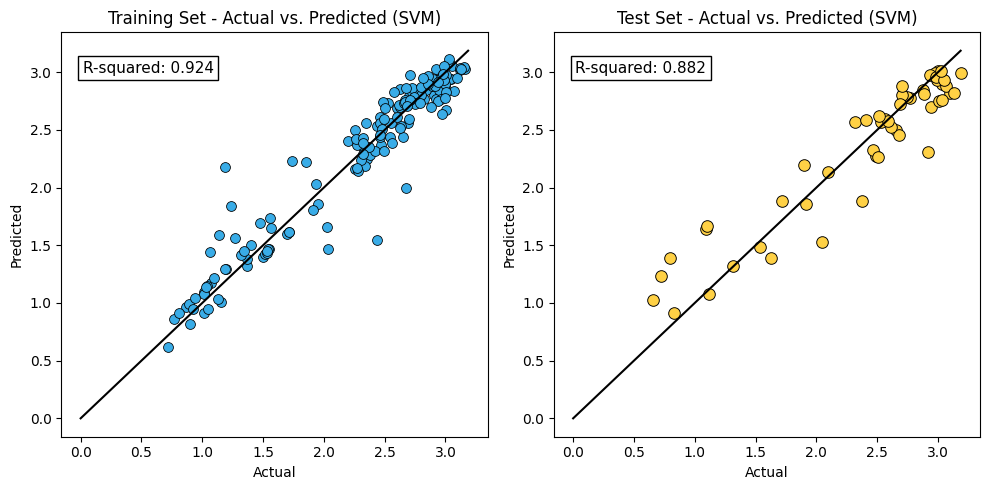

In [28]:
# Predict on training and test sets
y_train_pred = model_SVM.predict(X_train)
y_test_pred = model_SVM.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].set_title('Training Set - Actual vs. Predicted (SVM)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].set_title('Test Set - Actual vs. Predicted (SVM)')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

plt.tight_layout()
plt.show()

In [29]:
from sklearn.neural_network import MLPRegressor
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard', poly = 2, transform= 'yeo-johnson'), X.columns )])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('mlp', MLPRegressor(random_state=42))
])

parameter = {
    "mlp__alpha": [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03],
    "mlp__hidden_layer_sizes": [(16, 8, 4), (16, 4), (8, 4), (13, 8, 2), (32, 16, 2), (64, 32, 16, 8, 4, 2)],
    "mlp__learning_rate_init": [0.001, 0.005, 0.01],
    "mlp__activation": ["identity"]
}

model_ANN = RandomizedSearchCV(pipeline, parameter, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model_ANN.fit(X_train, y_train)

print(model_ANN.best_params_)
print(model_ANN.score(X_train, y_train), model_ANN.best_score_, model_ANN.score(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/jcopml/pipeline/_pipeline.py:66: UserWarning: Transformer has default standardization, so the scaling argument is neglected
  warn("Transformer has default standardization, so the scaling argument is neglected")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'mlp__learning_rate_init': 0.01, 'mlp__hidden_layer_sizes': (16, 8, 4), 'mlp__alpha': 0.003, 'mlp__activation': 'identity'}
0.8259776729858602 0.785902327076165 0.8951271366500456


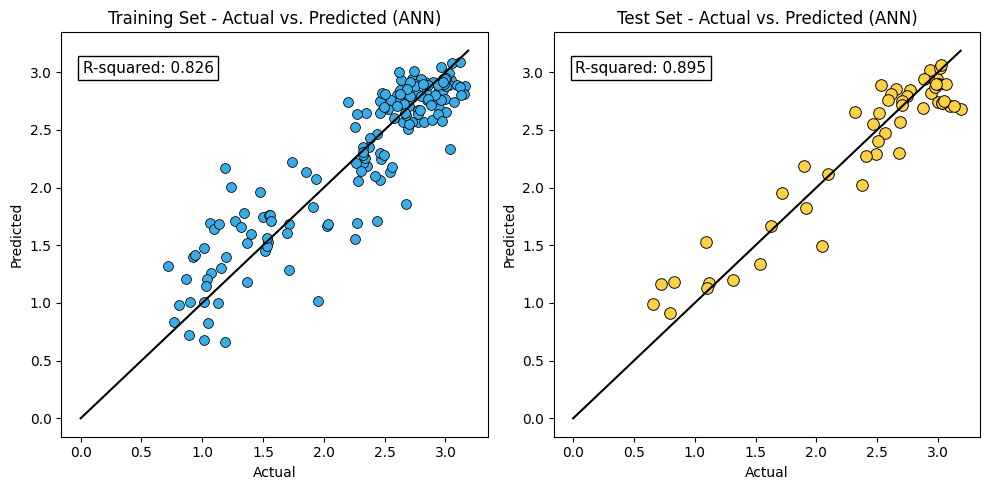

In [30]:
# Predict on training and test sets
y_train_pred = model_ANN.predict(X_train)
y_test_pred = model_ANN.predict(X_test)

# Calculate R-squared scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create dataframes with the actual and predicted values for training and test sets
train_data = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred})
test_data = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})

# Create separate plots for training and test sets
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training set
sns.scatterplot(data=train_data, x='Actual', y='Predicted', ax=axes[0],s=50, color='#39ACE7', edgecolor='black')
axes[0].set_title('Training Set - Actual vs. Predicted (ANN)')
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[0].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

# Add R-squared score as text inside the plot
axes[0].text(0.05, 0.9, f'R-squared: {train_r2:.3f}', transform=axes[0].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

# Plot test set
sns.scatterplot(data=test_data, x='Actual', y='Predicted', ax=axes[1],s=70, color='#ffd145', edgecolor='black')
axes[1].set_title('Test Set - Actual vs. Predicted (ANN)')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')

# Add 1:1 line extending from (0, 0) to upper right corner
axes[1].plot([0, max(y_train.max(), y_test.max())], [0, max(y_train.max(), y_test.max())], color='black', linestyle='-')

axes[1].text(0.05, 0.9, f'R-squared: {test_r2:.3f}', transform=axes[1].transAxes, fontsize=11,
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='square'))

plt.tight_layout()
plt.show()

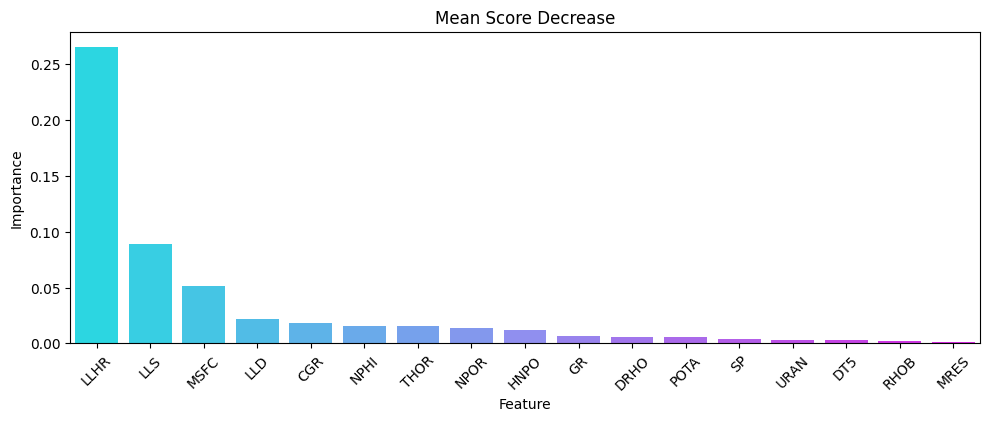

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from jcopml.plot import plot_residual

def plot_residual(df_imp):
    plt.figure(figsize=(10, 4.325))
    sns.barplot(x='feature', y='importance', data=df_imp, palette='cool')
    plt.xticks(rotation=45)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Mean Score Decrease')
    plt.tight_layout()
    plt.show()

df_imp = mean_score_decrease(X_train, y_train, model_RF, plot=False, topk=18)
plot_residual(df_imp.head(18))